In [5]:
import random
from pathlib import Path
import os
os.environ["VRE_LOGLEVEL"] = "0"
from pprint import pprint
from dronescapes_representations import dronescapes_task_types
from vre.readers import MultiTaskDataset
from vre.utils import image_write
from semantic_mapper import add_tasks_to_reader, run_vre, plot_one

import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define the data path.
It can be a normal video (mp4) or a previous export of VRE if it contains the 6 relevant 'seed' experts:
- rgb
- opticalflow_rife
- depth_marigold
- normals_svd(depth_marigold)
- semantic_mask2former_mapillary_49189528_0
- semantic_mask2former_coco_47429163_0

You can also generate it using `vre /path/to/video.mp4 -o out_dir --config_path cfg.yaml`

In [6]:
data_path = Path.cwd() / "../../resources/test_video.mp4" # dir of VRE export or just an MP4 (and vre is ran!)
if data_path.suffix == ".mp4":
    data_path = run_vre(data_path)

[2024-11-11T18:00:17 VRE-INFO] Building 'depth/marigold' (vre name: depth_marigold) (build_representations.py:build_representation_from_cfg:76)
[2024-11-11T18:00:17 VRE-INFO] Building 'semantic-segmentation/mask2former' (vre name: semantic_mask2former_coco_47429163_0) (build_representations.py:build_representation_from_cfg:76)
[2024-11-11T18:00:17 VRE-INFO] Building 'semantic-segmentation/mask2former' (vre name: semantic_mask2former_mapillary_49189528_0) (build_representations.py:build_representation_from_cfg:76)
[2024-11-11T18:00:17 VRE-INFO] Building 'optical-flow/rife' (vre name: opticalflow_rife) (build_representations.py:build_representation_from_cfg:76)
[2024-11-11T18:00:17 VRE-INFO] Building 'default/rgb' (vre name: rgb) (build_representations.py:build_representation_from_cfg:76)
[2024-11-11T18:00:17 VRE-INFO] Building 'normals/depth-svd' (vre name: normals_svd(depth_marigold)) (build_representations.py:build_representation_from_cfg:76)
[2024-11-11T18:00:20 VRE-INFO] [VRERuntime

### Instantiate the MultiTaskDataset object

This is only done for the initial seed expert tasks defined earlier. We'll also plot them.

[2024-11-11T18:01:51 VRE-INFO] Tasks used in this dataset: ['depth_marigold', 'normals_svd(depth_marigold)', 'opticalflow_rife', 'rgb', 'semantic_mask2former_coco_47429163_0', 'semantic_mask2former_mapillary_49189528_0'] (multitask_dataset.py:__init__:80)


[MultiTaskDataset]
 - Path: '/home/mihai/code/ml/video-representations-extractor/examples/semantic_mapper/data_test_video.mp4'
 - Tasks (6): [DepthRepresentation(depth_marigold ['depth_marigold']), NormalsRepresentation(normals_svd(depth_marigold) ['normals_svd(depth_marigold)']), OpticalFlowRepresentation(opticalflow_rife ['opticalflow_rife']), RGBRepresentation(rgb ['rgb']), SemanticRepresentation(semantic_mask2former_coco_47429163_0 ['semantic_mask2former_coco_47429163_0']), SemanticRepresentation(semantic_mask2former_mapillary_49189528_0 ['semantic_mask2former_mapillary_49189528_0'])]
 - Length: 5
 - Handle missing data mode: 'fill_nan'
 - Normalization: '{'depth_marigold': 'min_max', 'normals_svd(depth_marigold)': 'min_max', 'opticalflow_rife': 'min_max', 'rgb': 'min_max', 'semantic_mask2former_coco_47429163_0': 'min_max', 'semantic_mask2former_mapillary_49189528_0': 'min_max'}'
== Shapes ==


[2024-11-11T18:01:51 VRE-INFO] Computing global task statistics (dataset len 5) for ['depth_marigold', 'normals_svd(depth_marigold)', 'rgb', 'opticalflow_rife'] (statistics.py:compute_statistics:41)


{'depth_marigold': (540, 960),
 'normals_svd(depth_marigold)': (540, 960, 3),
 'opticalflow_rife': (540, 960, 2),
 'rgb': (540, 960, 3),
 'semantic_mask2former_coco_47429163_0': (540, 960, 133),
 'semantic_mask2former_mapillary_49189528_0': (540, 960, 65)}


[2024-11-11T18:01:52 VRE-INFO] Computed task statistics: {'depth_marigold': (1,), 'normals_svd(depth_marigold)': (3,), 'rgb': (3,), 'opticalflow_rife': (2,)} (statistics.py:compute_statistics:43)


1360.npz


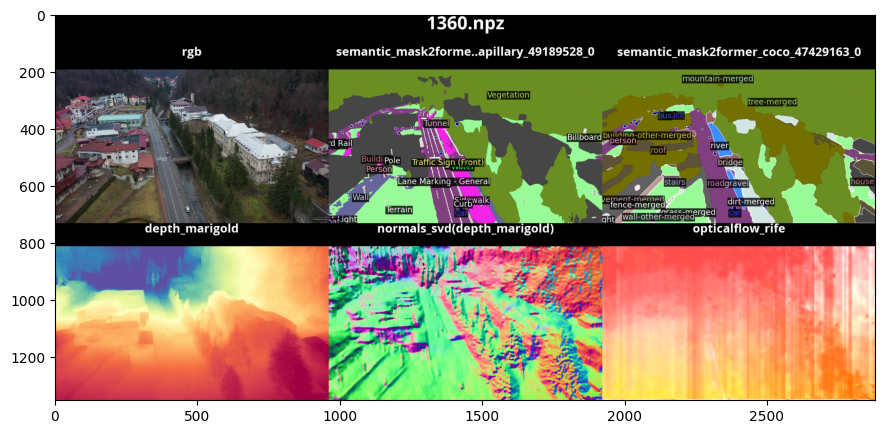

In [7]:
INCLUDE_SEMANTICS_ORIGINAL = True
task_names = ["rgb", "depth_marigold", "normals_svd(depth_marigold)", "opticalflow_rife"]
order = ["rgb", "depth_marigold", "normals_svd(depth_marigold)"]
if INCLUDE_SEMANTICS_ORIGINAL:
    task_names.extend(["semantic_mask2former_coco_47429163_0", "semantic_mask2former_mapillary_49189528_0"])
    order = ["rgb", "semantic_mask2former_mapillary_49189528_0", "semantic_mask2former_coco_47429163_0",
             "depth_marigold", "normals_svd(depth_marigold)"]

reader = MultiTaskDataset(data_path, task_names=task_names,
                          task_types=dronescapes_task_types, handle_missing_data="fill_nan",
                          normalization="min_max", cache_task_stats=True, batch_size_stats=100)
print(reader)
print("== Shapes ==")
pprint(reader.data_shape)

data, name, _ = reader[0]
plt.figure(figsize=(15, 5))
plt.imshow(collage := plot_one(data, title=name, order=order, name_to_task=reader.name_to_task))
plt.show()


### Add the newly defined tasks

Thery are read from `semantic_mapper.py` but you can define new ones here too using the primitives from there.
Each of them is added to the MultiTaskDataset object one by one.

[2024-11-11T18:01:54 VRE-INFO] Adding a new task: 'buildings' (multitask_dataset.py:add_task:195)
[2024-11-11T18:01:54 VRE-INFO] Adding a new task: 'living-vs-non-living' (multitask_dataset.py:add_task:195)
[2024-11-11T18:01:54 VRE-INFO] Adding a new task: 'sky-and-water' (multitask_dataset.py:add_task:195)
[2024-11-11T18:01:54 VRE-INFO] Adding a new task: 'transportation' (multitask_dataset.py:add_task:195)
[2024-11-11T18:01:54 VRE-INFO] Adding a new task: 'containing' (multitask_dataset.py:add_task:195)
[2024-11-11T18:01:54 VRE-INFO] Adding a new task: 'buildings(nearby)' (multitask_dataset.py:add_task:195)
[2024-11-11T18:01:54 VRE-INFO] Adding a new task: 'safe-landing-no-sseg' (multitask_dataset.py:add_task:195)
[2024-11-11T18:01:54 VRE-INFO] Adding a new task: 'safe-landing-semantics' (multitask_dataset.py:add_task:195)


== Random loaded item ==
2403.npz


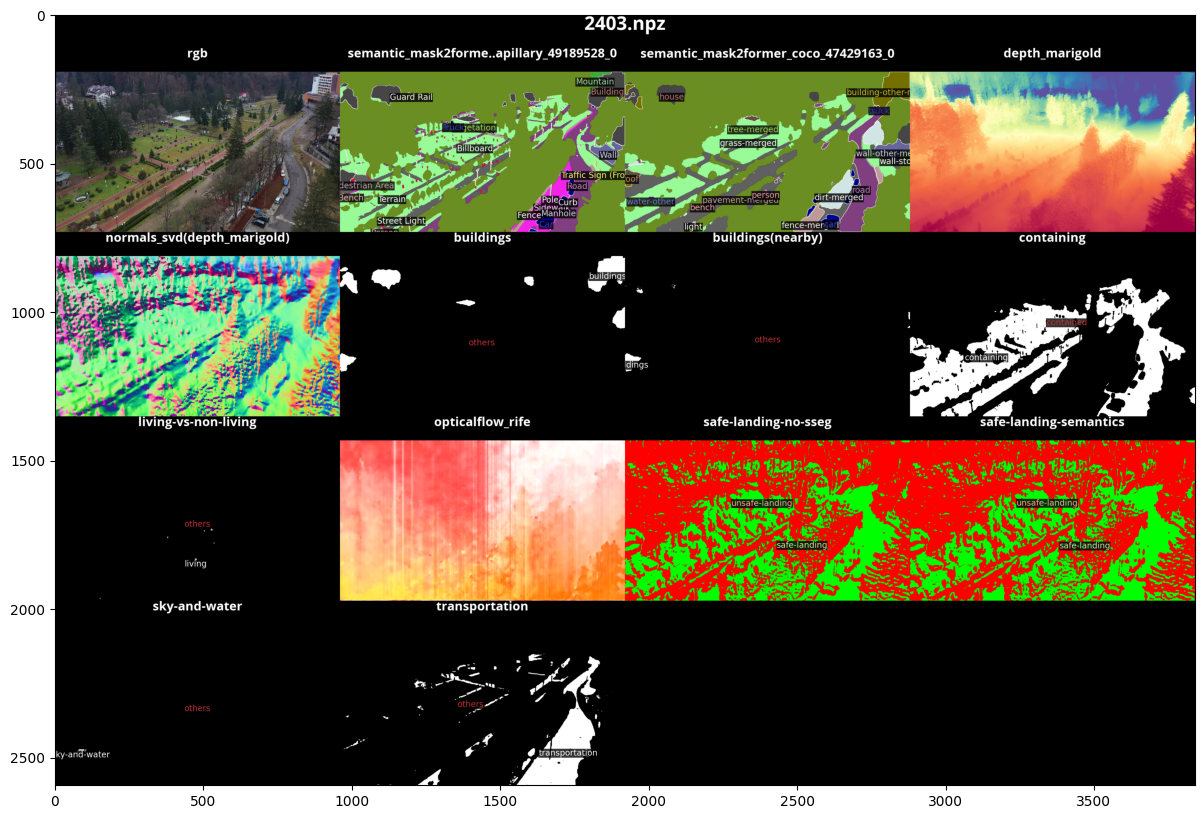

In [8]:
orig_task_names = list(reader.task_types.keys())
add_tasks_to_reader(reader, orig_task_names)

print("== Random loaded item ==")
rand_ix = random.randint(0, len(reader) - 1)
ixs = np.random.permutation(range(len(reader))).tolist()
for ix in ixs:
    data, name, _ = reader[ix] # get a random item
    plt.figure(figsize=(20, 10))
    plt.imshow(collage := plot_one(data, title=name, order=order, name_to_task=reader.name_to_task))
    plt.show()
    # image_write(collage, f"collage_{name[0:-4]}.png")
    break